In [1]:
import os
import pandas as pd
import seaborn as sns
from fitting.utils import get_output_dirs, get_best_model_version

sns.set_style('white')
sns.set_context('poster')

### plot train/val losses as a function of epochs

In [13]:
metrics_df = []

# labs = ['steinmetz', 'steinmetz-face', 'musall', 'datta']
labs = ['datta']
model_types = ['conv', 'linear']
hparams = {
    'data_dir': '/home/mattw/data',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet',
    'experiment_name': 'test_tf',
    'model_class': 'ae'}

for lab in labs:
    get_lab_example(hparams, lab)
    if lab == 'datta':
        hparams['experiment_name'] = 'test_tf0'
    else:
        hparams['experiment_name'] = 'test_tf'
    for model_type in model_types:
        hparams['model_type'] = model_type     
        _, _, expt_dir = get_output_dirs(hparams)
        model_version = get_best_model_version(expt_dir)
        metric_file = os.path.join(expt_dir, model_version[0], 'metrics.csv')
        metrics = pd.read_csv(metric_file)
        for i, row in metrics.iterrows():
            metrics_df.append(pd.DataFrame({
                'epoch': row['epoch'],
                'loss': row['val_loss'],
                'dtype': 'val',
                'model_type': model_type,
                'data': lab
            }, index=[0]))
            metrics_df.append(pd.DataFrame({
                'epoch': row['epoch'],
                'loss': row['tr_loss'],
                'dtype': 'train',
                'model_type': model_type,
                'data': lab
            }, index=[0]))
            if 'test_loss' in row:
                metrics_df.append(pd.DataFrame({
                    'epoch': row['epoch'],
                    'loss': row['test_loss'],
                    'dtype': 'test',
                    'model_type': model_type,
                    'data': lab
                }, index=[0]))
metrics_df = pd.concat(metrics_df)    

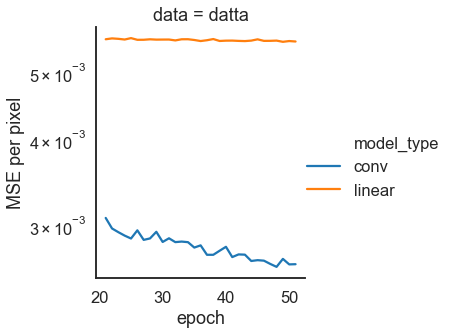

In [14]:
sns.set_style('white')
sns.set_context('talk')

# data_queried = metrics[~pd.notna(metrics.test_loss)]
data_queried = metrics_df[(metrics_df.dtype=='val') & (metrics_df.epoch>20)]
y_axis = 'loss' # 'test_loss' | 'test_r2'
plot_type = 'line'
hue = 'model_type'
x_axis = 'epoch' # 'layers' | 'layer_size' | 'pred' | 'lags'
col = 'data'

splt = sns.relplot(
    x=x_axis, y=y_axis, hue=hue, kind=plot_type, col=col, data=data_queried)
for i, ax in enumerate(splt.axes):
    ax[0].set_yscale('log')
    if i == 0:
        ax[0].set_ylabel('MSE per pixel')

In [ ]:
data_queried = metrics_df[metrics_df.dtype=='test']
y_axis = 'loss' # 'test_loss' | 'test_r2'
plot_type = 'boxen'
hue = 'model_type'
x_axis = 'data' # 'layers' | 'layer_size' | 'pred' | 'lags'

splt = sns.catplot(
    x=x_axis, y=y_axis, hue=hue, kind=plot_type, data=data_queried)
for i, ax in enumerate(splt.axes):
    ax[0].set_yscale('log')
    if i == 0:
        ax[0].set_ylabel('MSE per pixel')

### plot test losses as a function of latents

In [ ]:
metrics_df = []

hparams['experiment_name'] = 'best'
labs = ['musall']
model_types = ['conv', 'linear']
n_latents = [4, 8, 12, 16, 24, 64]

for lab in labs:
    get_lab_example(hparams, lab)
    for model_type in model_types:
        hparams['model_type'] = model_type
        for n_ae_latents in n_latents:
            hparams['n_ae_latents'] = n_ae_latents
            _, _, expt_dir = get_output_dirs(hparams)
            model_version = get_best_model_version(expt_dir)
            metric_file = os.path.join(expt_dir, model_version[0], 'metrics.csv')
            metrics = pd.read_csv(metric_file)
            for i, row in metrics.iterrows():
                metrics_df.append(pd.DataFrame({
                    'epoch': row['epoch'],
                    'loss': row['val_loss'],
                    'n_latents': n_ae_latents,
                    'dtype': 'val',
                    'model_type': model_type,
                    'data': lab
                }, index=[0]))
                metrics_df.append(pd.DataFrame({
                    'epoch': row['epoch'],use_output_mask
                    'loss': row['tr_loss'],
                    'n_latents': n_ae_latents,
                    'dtype': 'train',
                    'model_type': model_type,
                    'data': lab
                }, index=[0]))
                if 'test_loss' in row:
                    metrics_df.append(pd.DataFrame({
                        'epoch': row['epoch'],
                        'loss': row['test_loss'],
                        'n_latents': n_ae_latents,
                        'dtype': 'test',
                        'model_type': model_type,
                        'data': lab
                    }, index=[0]))
metrics_df = pd.concat(metrics_df)    

In [ ]:
# data_queried = metrics[~pd.notna(metrics.test_loss)]
data_queried = metrics_df[metrics_df.dtype=='test']
y_axis = 'loss' # 'test_loss' | 'test_r2'
plot_type = 'line'
hue = 'model_type'
x_axis = 'n_latents' # 'layers' | 'layer_size' | 'pred' | 'lags'

splt = sns.relplot(
    x=x_axis, y=y_axis, hue=hue, kind=plot_type, data=data_queried)
for i, ax in enumerate(splt.axes):
    ax[0].set_yscale('log')
    if i == 0:
        ax[0].set_ylabel('MSE per pixel')

### make movie

In [1]:
file = '/home/mattw/results/behavenet/datta/inscopix/15566/2018-11-27/ae/conv/08_latents' + \
    '/test_tube_data/test_pt_bn/version_0/meta_tags.pkl'
import pickle
with open(file, 'rb') as f:
    meta = pickle.load(f)

Loading model defined in /home/mattw/results/behavenet/datta/inscopix/15566/2018-11-27/ae/conv/04_latents/test_tube_data/test_pt/version_0/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/datta/inscopix/15566/2018-11-27/ae/linear/04_latents/test_tube_data/test_pt/version_0/meta_tags.pkl
video saved to /home/mattw/results/temp/datta_+linear_test_pt_4.mp4


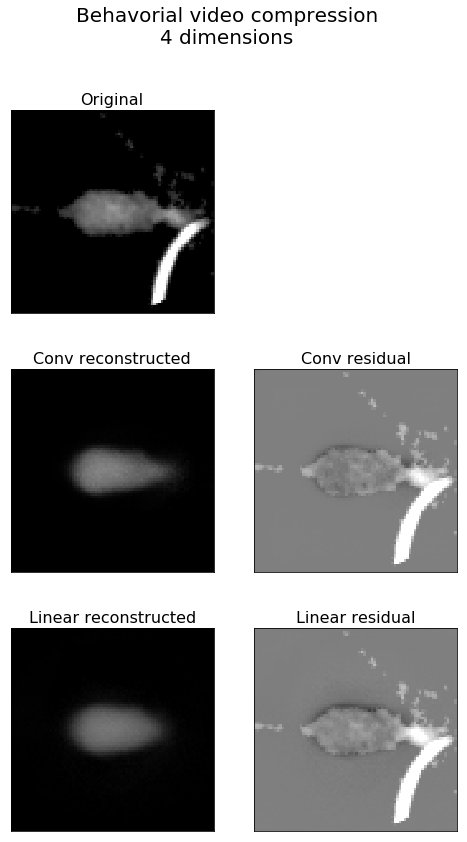

In [9]:
from analyses.ae.movies import reconstruction
from fitting.utils import get_lab_example
include_linear = True
version = 'best'
hparams = {
    'data_dir': '/home/mattw/data',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet',
    'experiment_name': 'test_pt',
    'model_class': 'ae',
    'model_type': 'conv',
    'lib': 'pt'}
lab = 'datta'
get_lab_example(hparams, lab)
hparams['n_ae_latents'] = 4

save_file = str('/home/mattw/results/temp/%s' % lab)
if include_linear:
    save_file += '_+linear'
# save_file += '_version_{}'.format(version)
save_file += '_%s' % hparams['experiment_name']
save_file += '_4'

reconstruction(
    hparams, trial=18, version=version, save_file=save_file, 
    include_linear=include_linear)